Tudo da vida segue uma distribuição gaussiana.
-V.C.A Marcelo

### Libraries

In [1]:
import pandas as pd
import numpy as np

Reading dataframes

In [2]:
df_gold = pd.read_csv('../data/d_gold.csv')
df_gold['date'] = pd.to_datetime(df_gold['date'], infer_datetime_format=True)

### Configuration

In [3]:
from sklearn.model_selection import train_test_split

data_x = np.arange(0, len(df_gold['date'])).reshape(-1,1)
data_y = np.array(df_gold['America'])

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20)
print("Train:", len(x_train))
print("Test:", len(x_test))

Train: 292
Test: 74


In [22]:
x_train[2][0]

311

## Linear Regression

[source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py)

Coeficiente:  -0.05591049113584972


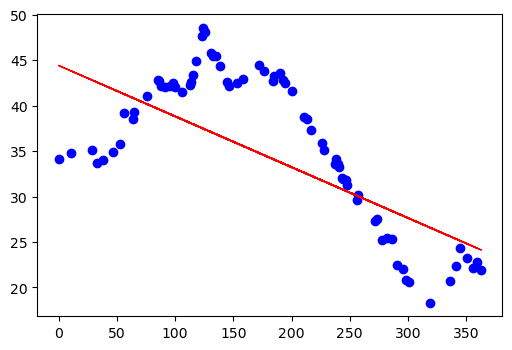

In [33]:
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

model = linear_model.LinearRegression()
model.fit(x_train, y_train.reshape(-1,1))

print("Coeficiente: ", model.coef_[0][0])

y_pred = model.predict(x_test)

plt.scatter(x_test, y_test, color="blue")
plt.plot(x_test, y_pred, color="red", linewidth=1)

## Polynomial interpolation

[source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)

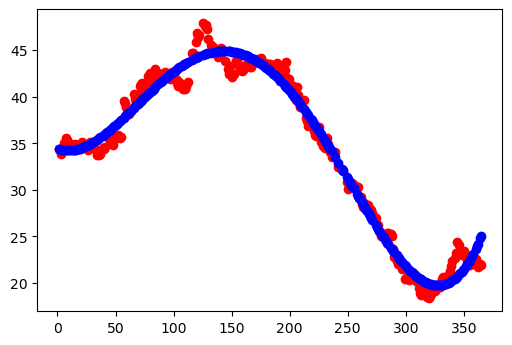

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=4)
x_poly = poly_reg.fit_transform(x_train)

pol_reg = LinearRegression()
pol_reg.fit(x_poly, y_train)

y_predict = pol_reg.predict(x_poly)

plt.scatter(x_train, y_train, color='red')
plt.scatter(x_train, y_predict, color='blue')
plt.show()

## Support Vector Rregression

[source here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

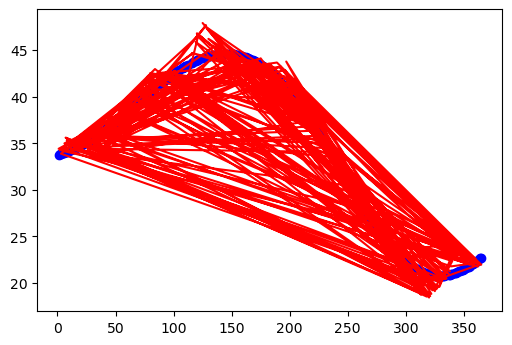

<function Pipeline.score at 0x0000022A1FCBC040>


In [34]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(x_train, y_train)

y_predict = regr.predict(x_train)

plt.plot(x_train, y_train, color='red')
plt.scatter(x_train, y_predict, color='blue')
plt.show()
print(regr.score)
#Pipeline(steps=[('standardscaler', StandardScaler()),('svr', SVR(epsilon=0.2))])

## LSTM

[source here](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)

In [ ]:
n_train = n_samples
n_test = n_predict

# Setup data
train_data = np.array(wowtoken[:n_train])
test_data = np.array(wowtoken[n_samples:n_samples+n_test])

train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Scaling 0 - 1
scaler = MinMaxScaler()

scaler.fit(train_data)
sc_train_data = scaler.transform(train_data).reshape(-1)

scaler.fit(test_data)
sc_test_data = scaler.transform(test_data).reshape(-1)

# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(n_test):
  EMA = gamma*sc_train_data[ti] + (1-gamma)*EMA
  sc_train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

## Prophet (nao tentei ainda)

In [ ]:
import pandas as pd
from fbprophet import Prophet